# WISE MBH est. compared to prev. est. and T-value comparison

In [1]:
import sys
sys.path.insert(0, '../Packages/')
import personal as f
import numpy as np 
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
from uncertainties import ufloat, unumpy
import uncertainties.umath as u
from scipy import stats
from astropy.cosmology import Planck18 as cosmo 

In [2]:
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}  #Settings for plots
sns.set_theme(style='ticks' ,context='paper', rc=custom_params)

In [3]:
no_data = 9876543
allwise = f.fits_to_df('../WISE/AllWISE_ETHER.fits').drop_duplicates(subset=['RAJ2000','DEJ2000']).reset_index(drop=True)
allwise.columns

Index(['angDist', 'ONAME', 'RA', 'DEC', 'Z', 'DIST', 'MBH', 'MBHHI', 'MBHLO',
       'MBHSOURCE', 'MBHPUB', 'MBHUPLIM', 'IS_VLBI', 'LOGLBOL', 'AllWISE',
       'RAJ2000', 'DEJ2000', 'eeMaj', 'eeMin', 'eePA', 'W1mag', 'W2mag',
       'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'e_W1mag', 'e_W2mag',
       'e_W3mag', 'e_W4mag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'ID', 'ccf', 'ex',
       'var', 'qph', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'd2M'],
      dtype='object')

In [4]:
allwise_positive_z = allwise[(allwise['Z']>0) & (allwise['Z']!=no_data)]
allwise_positive_z.head()

angDist                        ONAME          RA        DEC     Z  \
0  0.048716  b'WISEAJ222301.23-892309.1'  335.754058 -89.385872  0.90   
3  0.209600  b'WISEAJ032224.88-890636.7'   50.604774 -89.110263  1.30   
4  0.148824  b'WISEAJ200526.32-890341.6'  301.359882 -89.061621  1.20   
5  0.224874            b'IRAS22470-8915'  347.233400 -88.987190  0.02   
6  0.610340  b'WISEAJ110928.23-884822.7'  167.368725 -88.806145  0.10   

         DIST        MBH      MBHHI      MBHLO  MBHSOURCE  ...  \
0  1607.02450  9876543.0  9876543.0  9876543.0  9876543.0  ...   
3  1728.05930  9876543.0  9876543.0  9876543.0  9876543.0  ...   
4  1710.65050  9876543.0  9876543.0  9876543.0  9876543.0  ...   
5    83.59599  9876543.0  9876543.0  9876543.0  9876543.0  ...   
6   380.41315  9876543.0  9876543.0  9876543.0  9876543.0  ...   

                    ID      ccf  ex      var      qph   pmRA  e_pmRA   pmDE  \
0       89401351032935  b'0000'   0  b'0011'  b'AAAB'  132.0    48.0 -168.0   
3   600089401351043073  b'0000'   0  b'000n'  b'AAAB'  101.0    83.0  164.0   
4  3004089401351042961  b'0000'   0  b'0011'  b'AAAA' -163.0    59.0  -29.0   
5       89401351040435  b'0000'   5  b'1000'  b'AAAA' -174.0    37.0   19.0   
6  1802089401351059037  b'0000'   0  b'00nn'  b'AABU' -111.0   366.0  725.0   

   e_pmDE    d2M  
0    48.0  0.161  
3    87.0    NaN  
4    61.0  0.128  
5    35.0  0.233  
6   340.0    NaN  

[5 rows x 44 columns]

In [5]:
qph_list = allwise_positive_z['qph'].str.decode('utf8').to_list()       #Extract quality flags
no_conf = ['U', 'X', 'Z']                                       #Upper or Null values in W bands
booleans = [not any(letter in qph[:-1] for letter in no_conf) for qph in qph_list]        #Test quality flags

good_quality_wise = allwise_positive_z[booleans].copy()

qph_list = good_quality_wise['qph'].str.decode('utf8').to_list()                   #Extract quality flags

def quality_flag(value):
    if 'C' in value:
        return 'C'
    elif 'B' in value:
        return 'B'
    return 'A'

good_quality_wise['Quality'] = [quality_flag(qph[:-1]) for qph in qph_list]  

In [6]:
w1 = unumpy.uarray(good_quality_wise['W1mag'],good_quality_wise['e_W1mag'])
w2 = unumpy.uarray(good_quality_wise['W2mag'],good_quality_wise['e_W2mag'])
w3 = unumpy.uarray(good_quality_wise['W3mag'],good_quality_wise['e_W3mag'])
z = good_quality_wise['Z'].to_list()

w1abs = w1 - f.distance_modulus(z)

good_quality_wise['W1_abs'] = unumpy.nominal_values(w1abs)

w1w2 = w1-w2
w2w3 = w2-w3

good_quality_wise['W1W2'] = unumpy.nominal_values(w1w2)
good_quality_wise['W2W3'] = unumpy.nominal_values(w2w3)

In [7]:
log_sm = f.wise_to_logsm(w1abs, w1w2)
t_value = f.w2w3_to_morph(unumpy.nominal_values(w2w3))
bulge_ratio = f.morph_to_bulge_ratio(t_value)
log_bm = np.log10(bulge_ratio) + log_sm
log_mbh = f.bulge_to_mbh(log_bm)
comp_mbh = f.comp_mbh(log_mbh)

good_quality_wise['T'] = t_value
good_quality_wise['logSM'] = unumpy.nominal_values(log_sm)
good_quality_wise['WISE_MBH'] = unumpy.nominal_values(comp_mbh)

def cat_morph(value):
    if value<=-4:
        return 'Elliptical'
    elif value>-4 and value<=-1:          
        return 'Lenticular'
    elif value>-1:
        return 'Spiral'
    return None

good_quality_wise['MorphType'] = [cat_morph(i) for i in good_quality_wise['T']]

In [8]:
log_sm_mask = (good_quality_wise['logSM']>=9.22) & (good_quality_wise['logSM']<=12.86)
good_quality_wise = good_quality_wise[log_sm_mask]

In [9]:
pub_nums = good_quality_wise[(good_quality_wise['MBHPUB']!=no_data) & (good_quality_wise['MBHPUB']!=15) & (good_quality_wise['MBHPUB']!=9)]['MBHPUB'].unique()
pub_nums = [pub_num for pub_num in pub_nums if (good_quality_wise[good_quality_wise['MBHPUB']==pub_num]['MBHPUB'].value_counts()>2).to_list()[0]]
good_quality_wise['MBHPUB'].value_counts()

9876543    289080
0          257258
1          162769
37          15446
36           5134
31            728
33            345
32            184
34            142
35            131
10             74
12             64
40             61
44             46
30             21
11             17
43             13
41             11
13              9
14              6
20              6
15              1
9               1
Name: MBHPUB, dtype: int64

# Morph hue plots

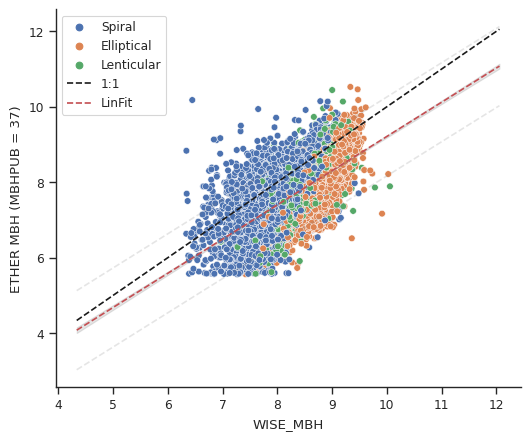

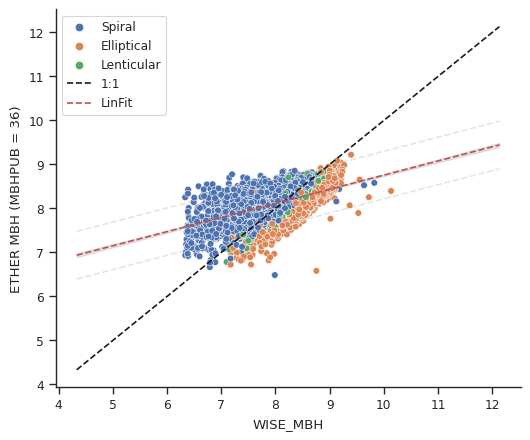

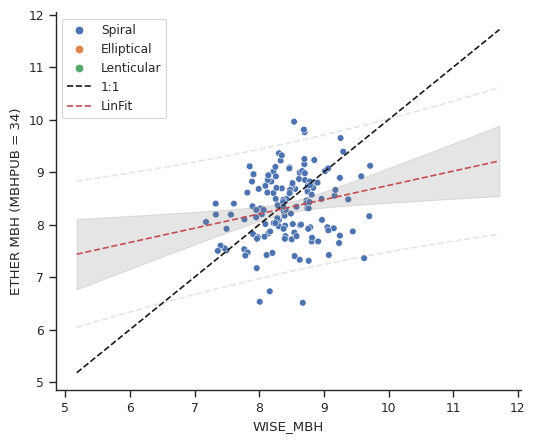

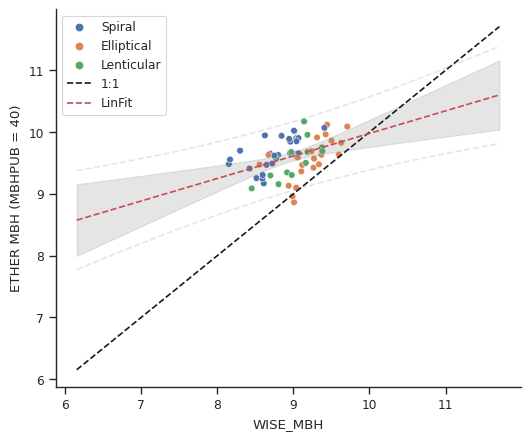

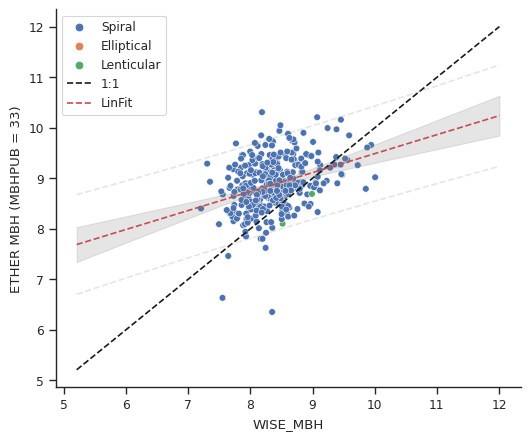

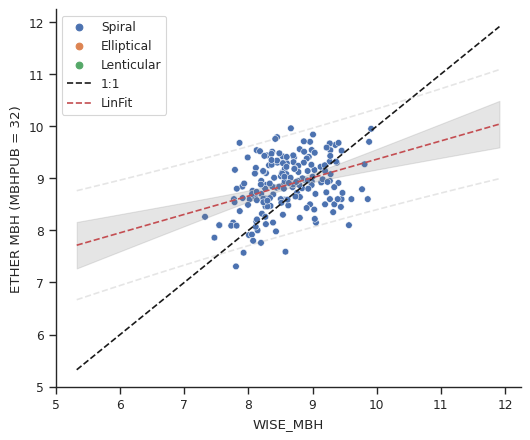

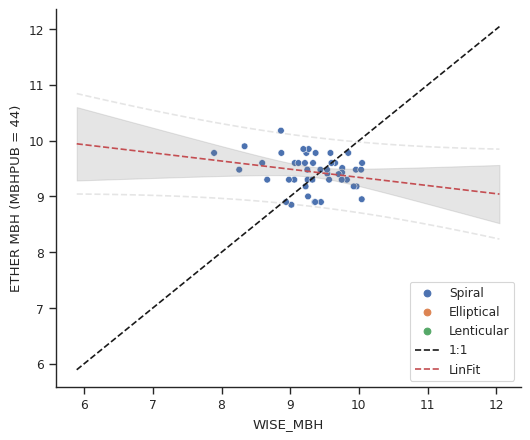

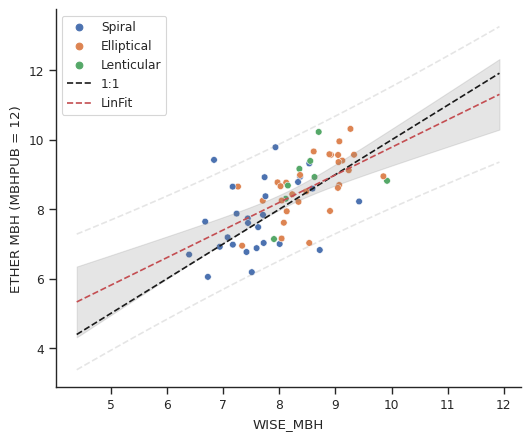

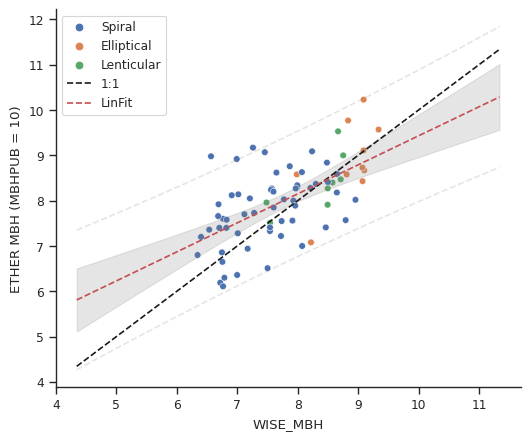

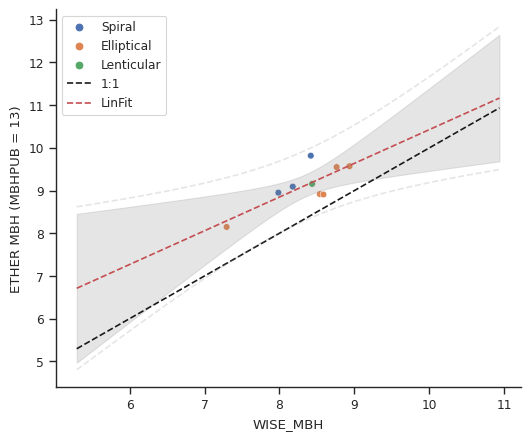

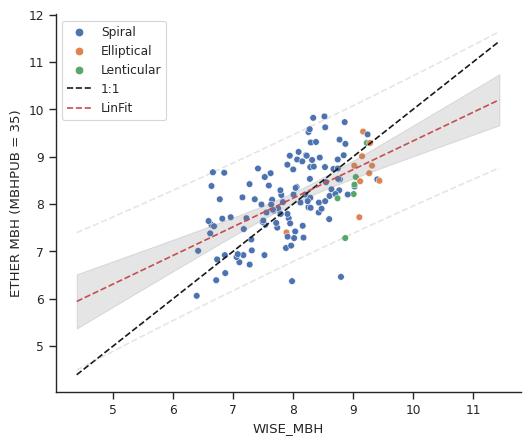

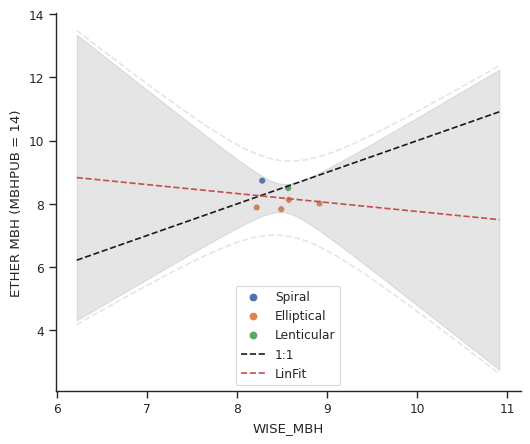

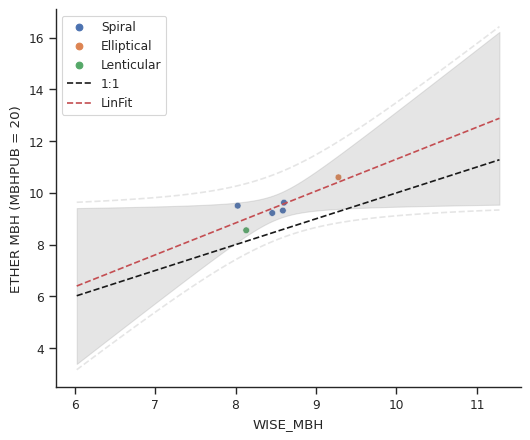

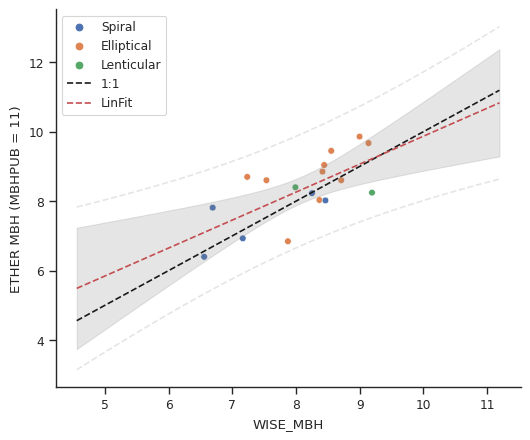

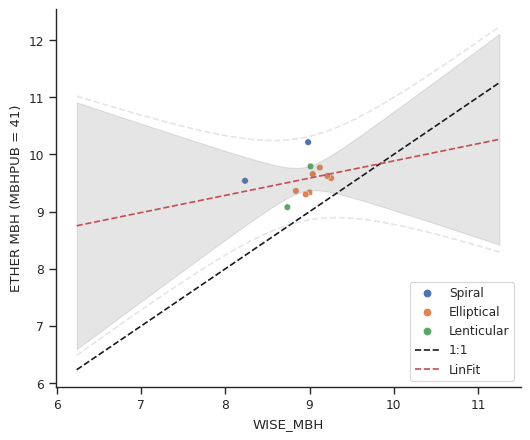

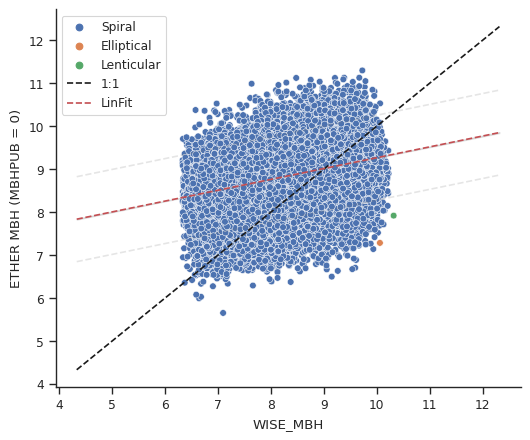

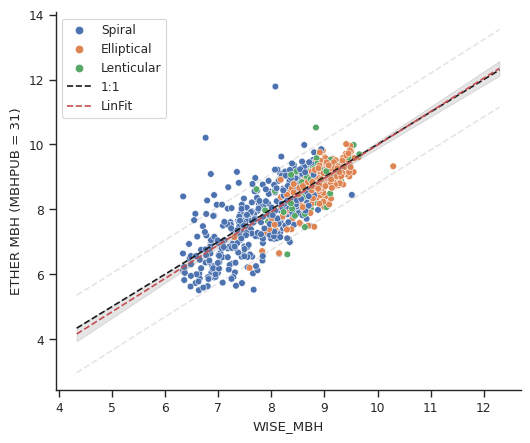

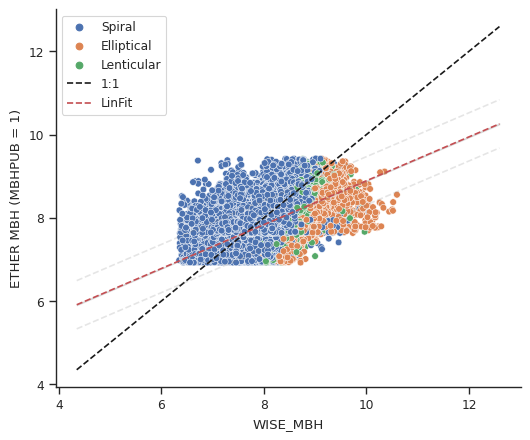

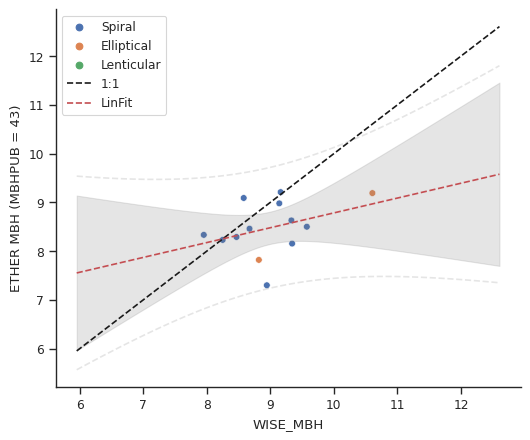

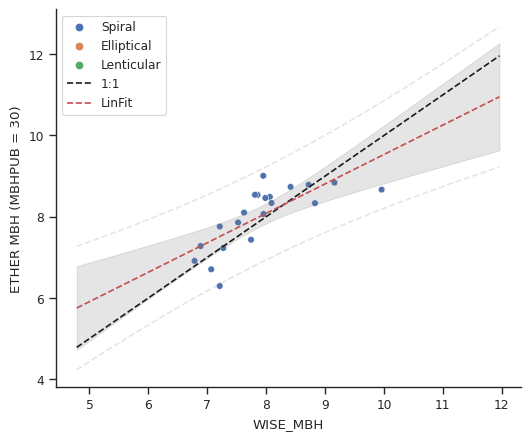

In [ ]:
hue_order = ['Spiral', 'Elliptical', 'Lenticular']
for pub_num in pub_nums:

    x2, y2, ci1, _, p, pi = f.linear_with_ci(good_quality_wise[good_quality_wise['MBHPUB']==pub_num]['WISE_MBH'], good_quality_wise[good_quality_wise['MBHPUB']==pub_num]['MBH'])
    xto1, yto1 = np.linspace(min(x2),max(x2),len(x2)), np.linspace(min(x2),max(x2),len(x2))

    plt.figure(figsize=(6,5), dpi=100)
    sns.scatterplot(x='WISE_MBH', y='MBH', data=good_quality_wise[good_quality_wise['MBHPUB']==pub_num], hue='MorphType',hue_order=hue_order)
    plt.plot(xto1,yto1, label='1:1', ls='--', c='k')

    plt.plot(x2, y2, '--r', zorder=2,label='LinFit')
    plt.plot(x2, y2-pi, linestyle='--', color='grey', alpha=0.2)
    plt.plot(x2, y2+pi, linestyle='--', color='grey', alpha=0.2)
    plt.fill_between(x2, y2 + ci1, y2 - ci1,color='grey',alpha=0.2)

    plt.ylabel('ETHER MBH (MBHPUB = {})'.format(pub_num))
    plt.legend()

    #plt.savefig('../Plots/WISE_Est/MBHPUB={}'.format(pub_num))

# Quality hue plots

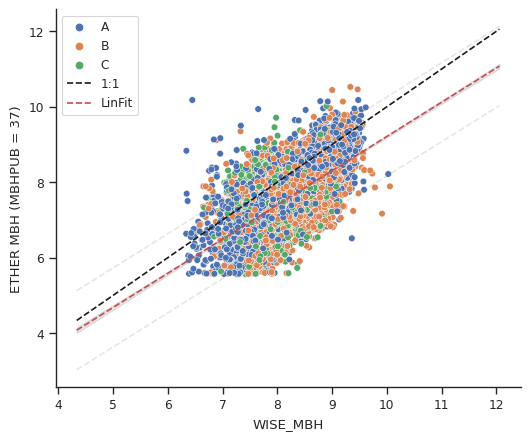

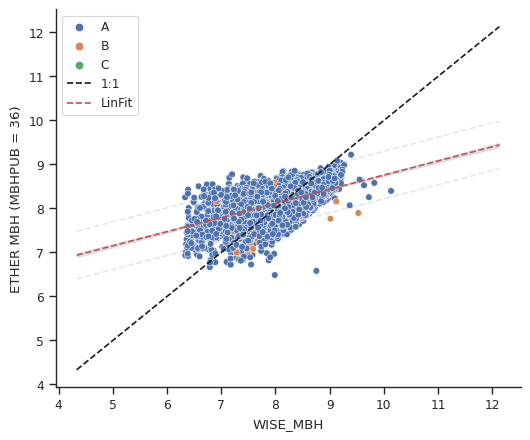

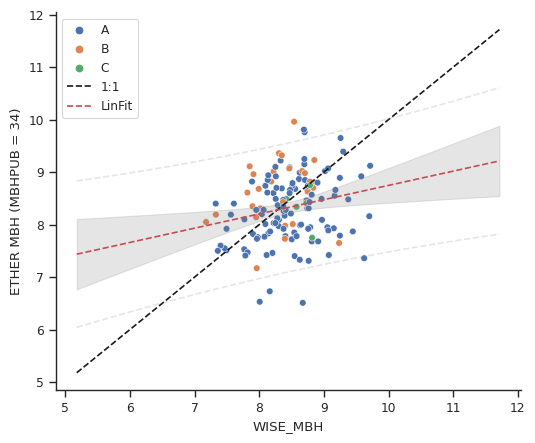

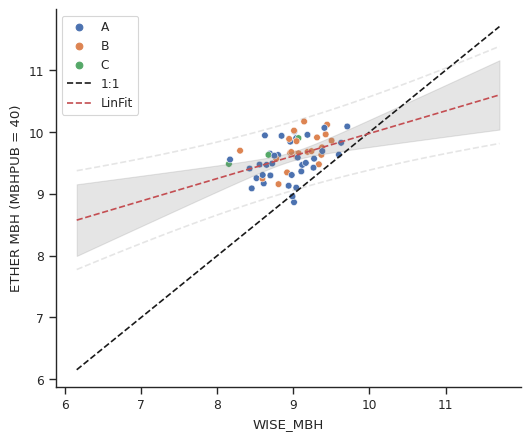

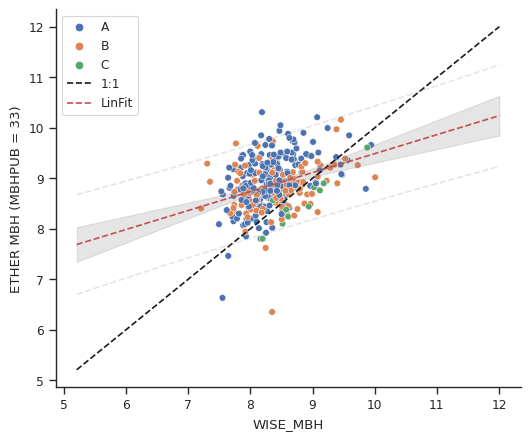

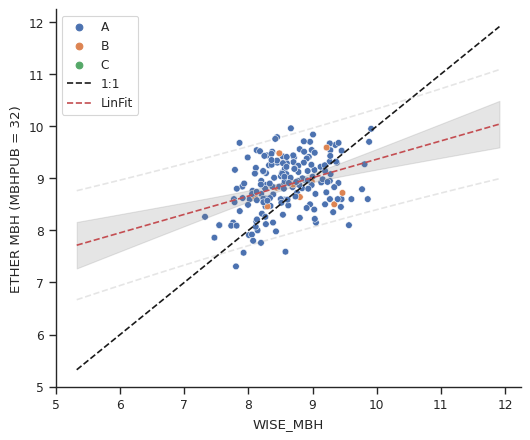

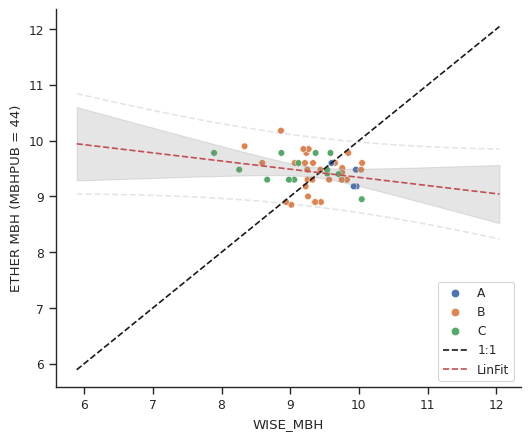

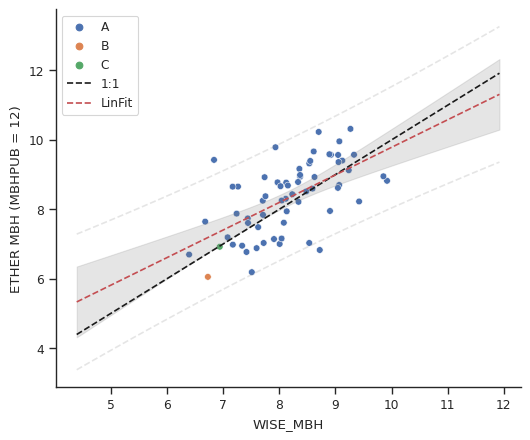

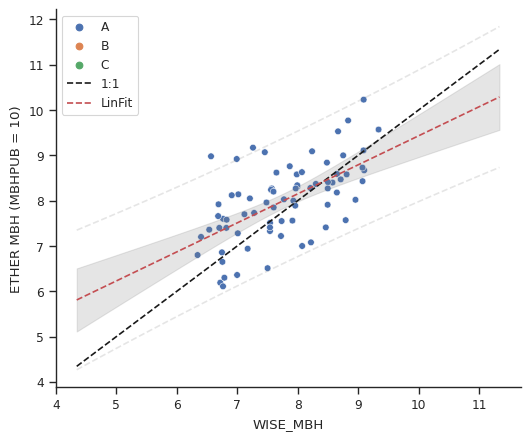

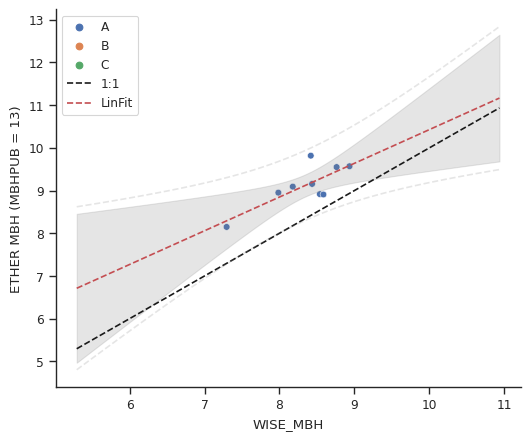

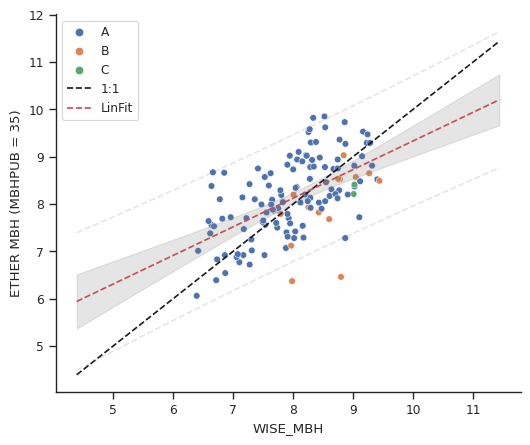

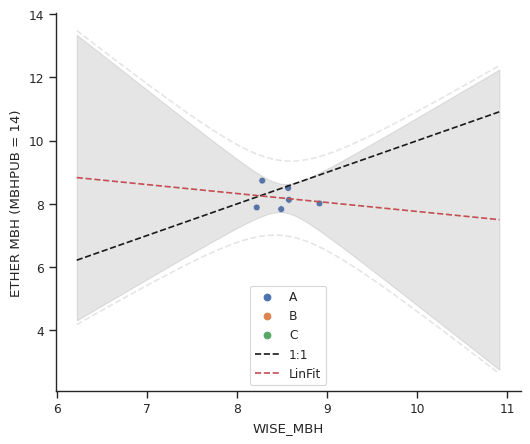

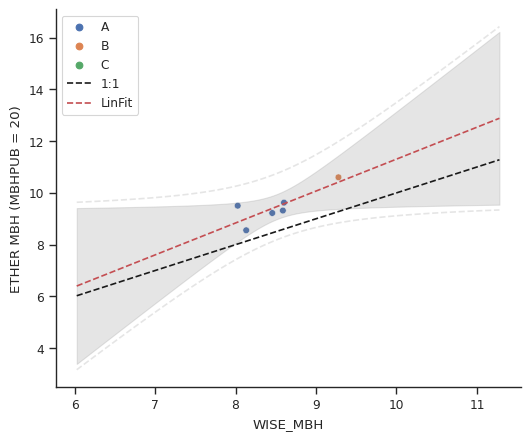

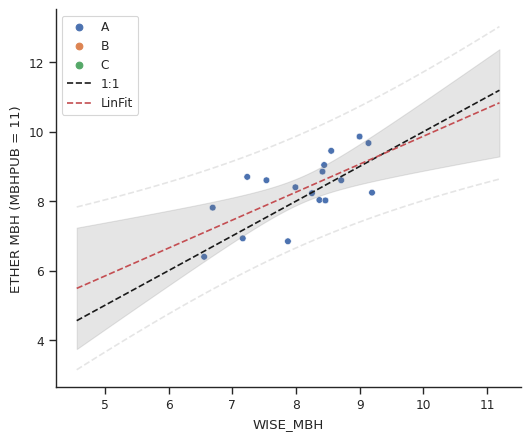

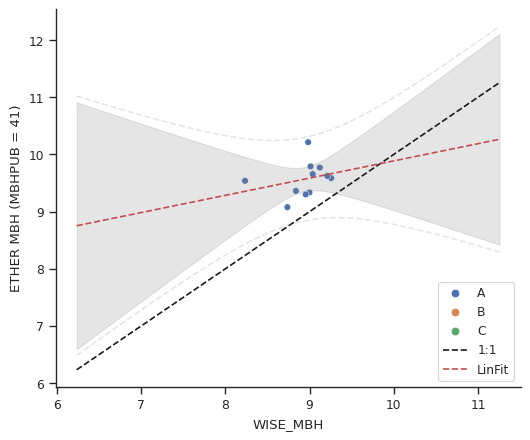

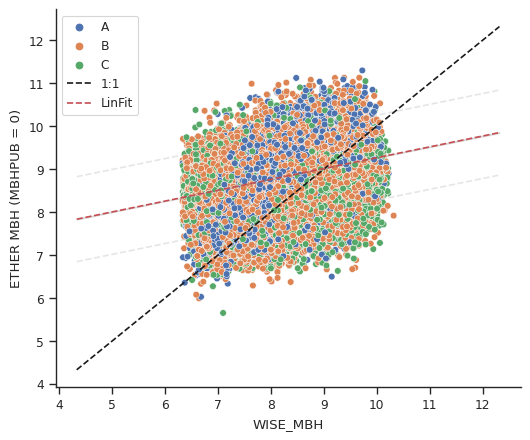

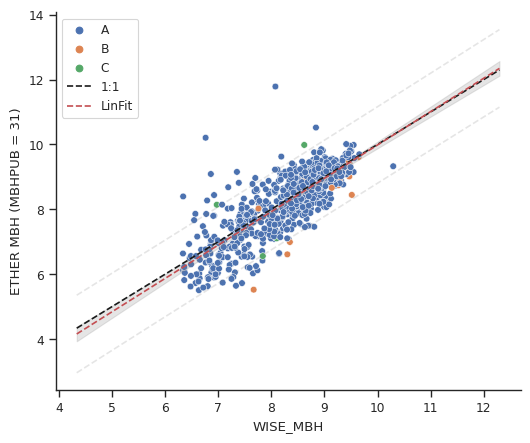

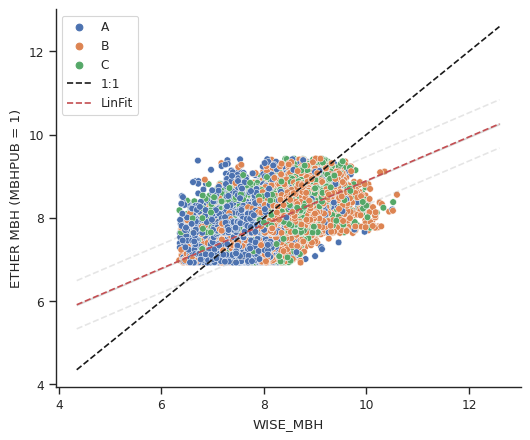

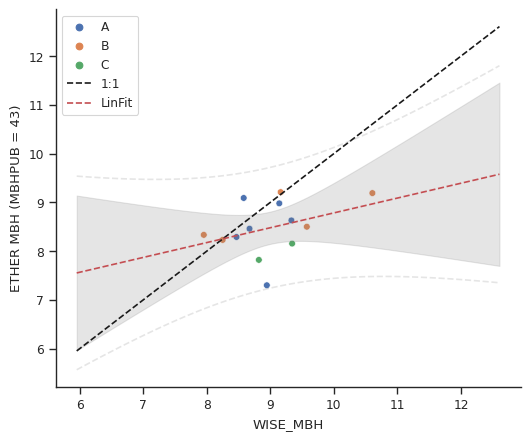

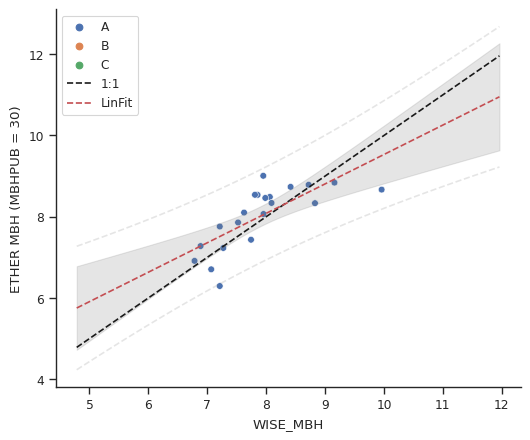

In [ ]:
hue_order = ['A', 'B', 'C']
for pub_num in pub_nums:

    x2, y2, ci1, _, p, pi = f.linear_with_ci(good_quality_wise[good_quality_wise['MBHPUB']==pub_num]['WISE_MBH'], good_quality_wise[good_quality_wise['MBHPUB']==pub_num]['MBH'])
    xto1, yto1 = np.linspace(min(x2),max(x2),len(x2)), np.linspace(min(x2),max(x2),len(x2))

    plt.figure(figsize=(6,5), dpi=100)
    sns.scatterplot(x='WISE_MBH', y='MBH', data=good_quality_wise[good_quality_wise['MBHPUB']==pub_num], hue='Quality',hue_order=hue_order)
    plt.plot(xto1,yto1, label='1:1', ls='--', c='k')

    plt.plot(x2, y2, '--r', zorder=2,label='LinFit')
    plt.plot(x2, y2-pi, linestyle='--', color='grey', alpha=0.2)
    plt.plot(x2, y2+pi, linestyle='--', color='grey', alpha=0.2)
    plt.fill_between(x2, y2 + ci1, y2 - ci1,color='grey',alpha=0.2)

    plt.ylabel('ETHER MBH (MBHPUB = {})'.format(pub_num))
    plt.legend()

    #plt.savefig('../Plots/WISE_Quality/MBHPUB={}.jpg'.format(pub_num))

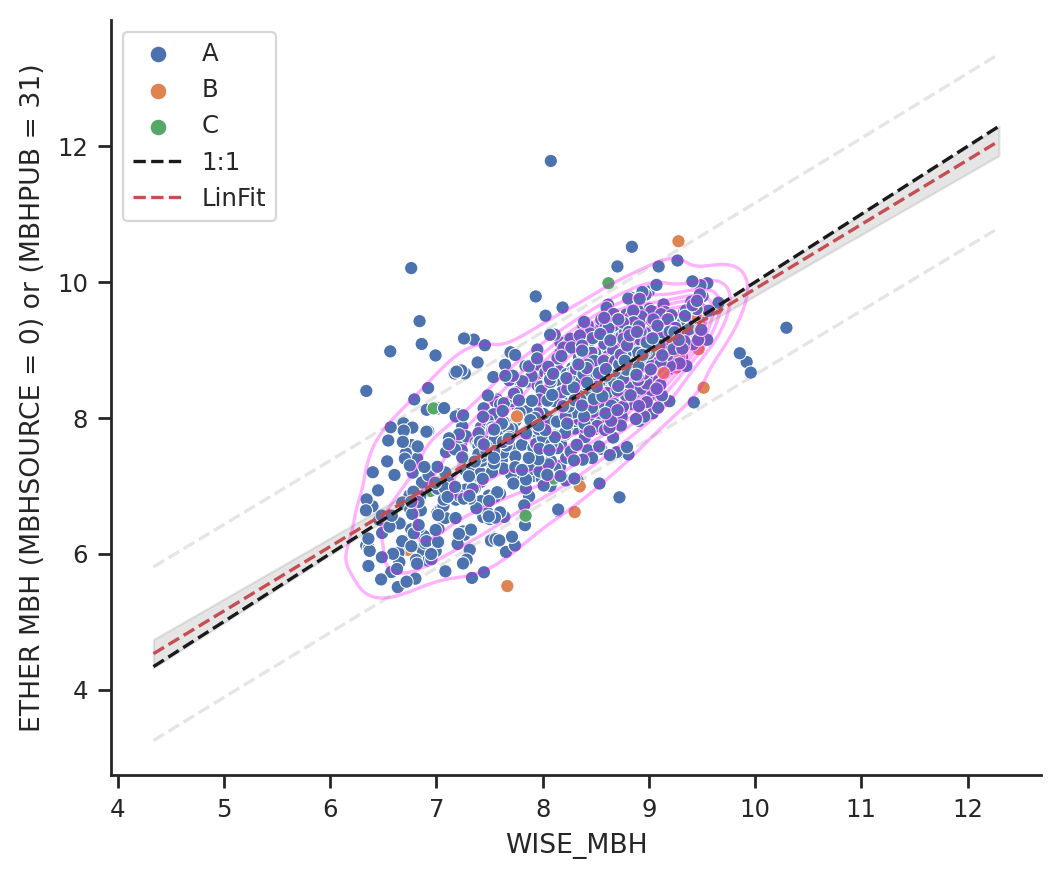

In [ ]:
x2, y2, ci1, _, p, pi = f.linear_with_ci(good_quality_wise[(good_quality_wise['MBHSOURCE']==0) | (good_quality_wise['MBHPUB']==31)]['WISE_MBH'], good_quality_wise[(good_quality_wise['MBHSOURCE']==0) | (good_quality_wise['MBHPUB']==31)]['MBH'])
xto1, yto1 = np.linspace(min(x2),max(x2),len(x2)), np.linspace(min(x2),max(x2),len(x2))

plt.figure(figsize=(6,5), dpi=200)
sns.kdeplot(x='WISE_MBH', y='MBH', data=good_quality_wise[(good_quality_wise['MBHSOURCE']==0) | (good_quality_wise['MBHPUB']==31)], color='magenta', alpha=0.3)
sns.scatterplot(x='WISE_MBH', y='MBH', data=good_quality_wise[(good_quality_wise['MBHSOURCE']==0) | (good_quality_wise['MBHPUB']==31)], hue='Quality',hue_order=hue_order)

plt.plot(xto1,yto1, label='1:1', ls='--', c='k')

plt.plot(x2, y2, '--r', zorder=2,label='LinFit')
plt.plot(x2, y2-pi, linestyle='--', color='grey', alpha=0.2)
plt.plot(x2, y2+pi, linestyle='--', color='grey', alpha=0.2)
plt.fill_between(x2, y2 + ci1, y2 - ci1,color='grey',alpha=0.2)

plt.ylabel('ETHER MBH (MBHSOURCE = 0) or (MBHPUB = 31)')
plt.legend()

plt.savefig('../Plots/WISE_Quality/MBHSOURCE=0.jpg')

In [ ]:
good_quality_wise.loc[good_quality_wise[(good_quality_wise['MBHSOURCE']==0) | (good_quality_wise['MBHPUB']==31)]['MBH'].idxmax()]

angDist                    0.241264
ONAME                 b'PGC3096769'
RA                        104.69208
DEC                        59.77758
Z                          0.068224
DIST                       269.2695
MBH                       11.784212
MBHHI                     12.261333
MBHLO                     11.307091
MBHSOURCE                       1.0
MBHPUB                           31
MBHUPLIM                        0.0
IS_VLBI                       False
LOGLBOL                   9876543.0
AllWISE      b'J065846.12+594639.3'
RAJ2000                  104.692207
DEJ2000                     59.7776
eeMaj                        0.0308
eeMin                        0.0291
eePA                          161.1
W1mag                         9.454
W2mag                         8.535
W3mag                         6.101
W4mag                         3.933
Jmag                         13.555
Hmag                          12.31
Kmag                          11.16
e_W1mag                     

# For VLBI sources only

In [13]:
vlbi_only = good_quality_wise[good_quality_wise['IS_VLBI']]
len(vlbi_only[vlbi_only['MBH']!=no_data])/len(vlbi_only)

0.3230359520639148

In [15]:
pub_nums_vlbi = vlbi_only[(vlbi_only['MBHPUB']!=no_data)]['MBHPUB'].unique()
pub_nums_vlbi = [pub_num for pub_num in pub_nums_vlbi if (vlbi_only[vlbi_only['MBHPUB']==pub_num]['MBHPUB'].value_counts()>2).to_list()[0]]
vlbi_only['MBHPUB'].value_counts()

9876543    5084
0          1354
33          255
1           222
32          179
34          119
37           69
35           63
36           40
31           37
44           27
10           21
40           18
12           10
43            3
20            3
11            3
30            2
13            1
Name: MBHPUB, dtype: int64

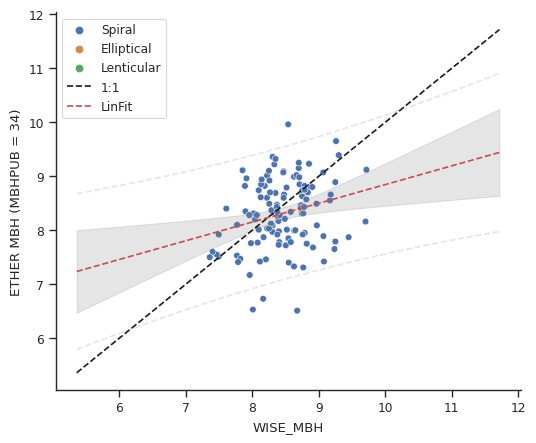

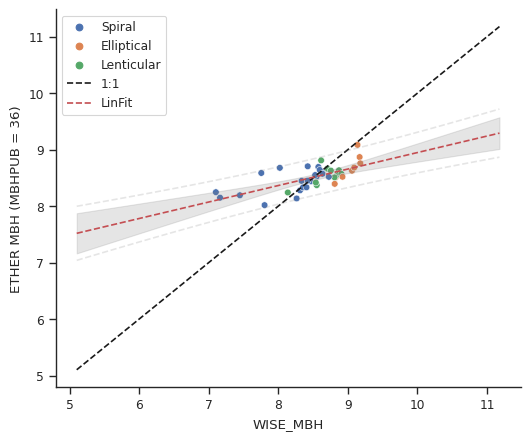

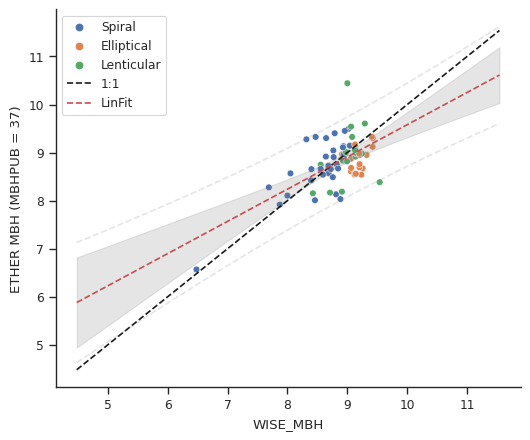

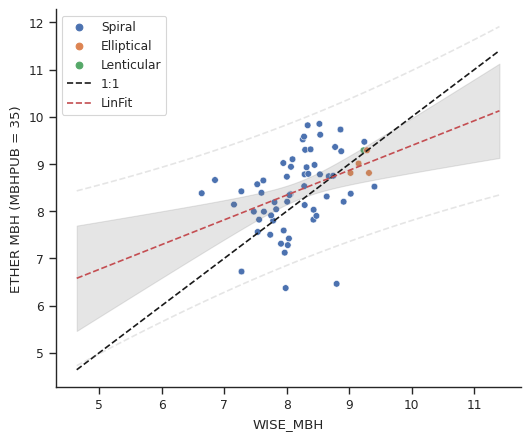

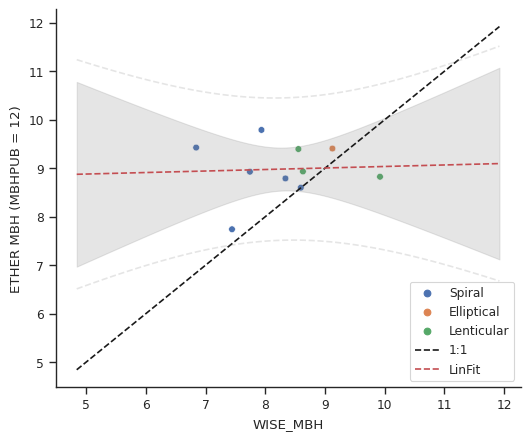

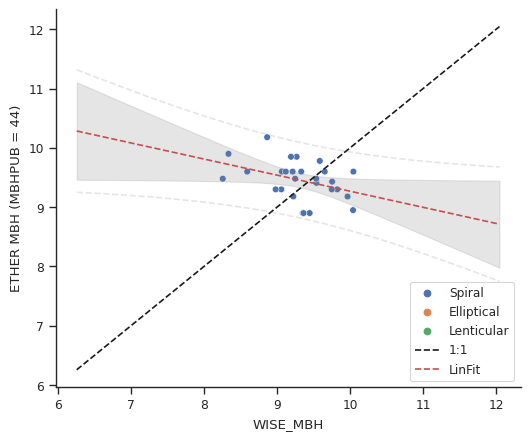

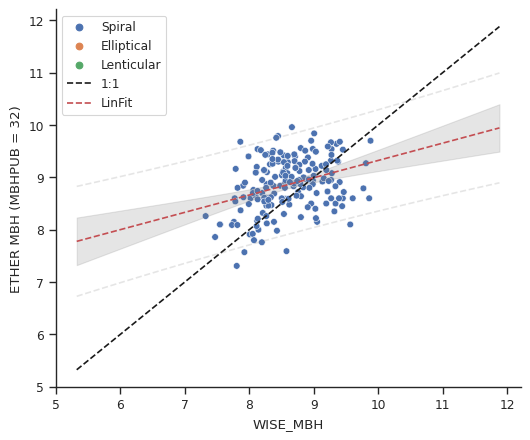

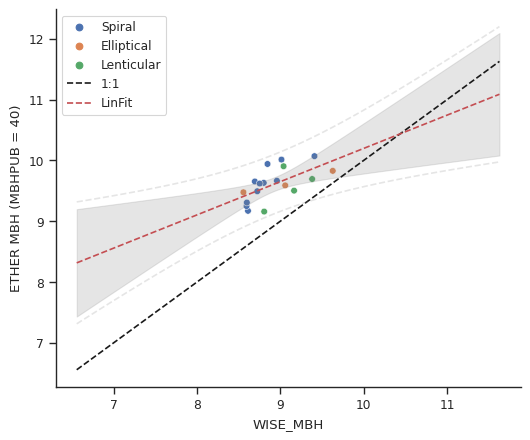

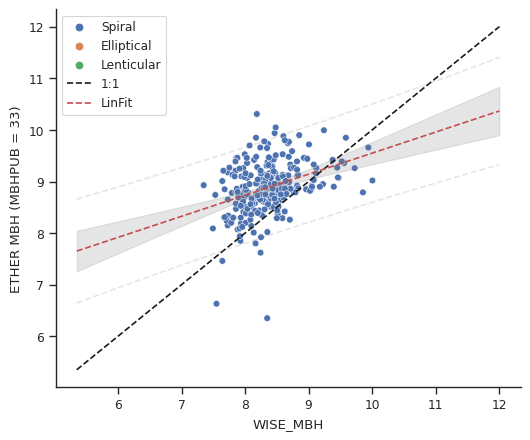

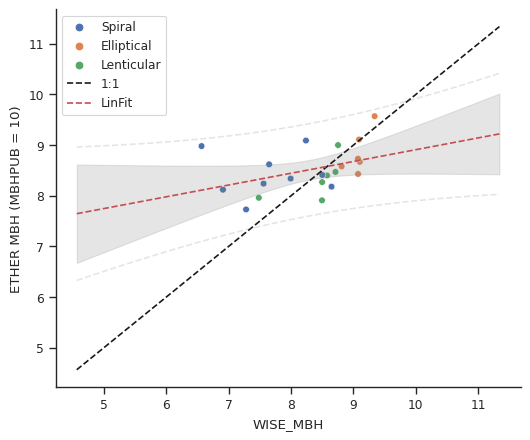

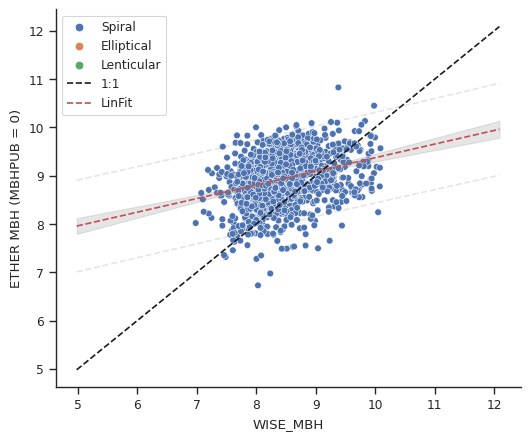

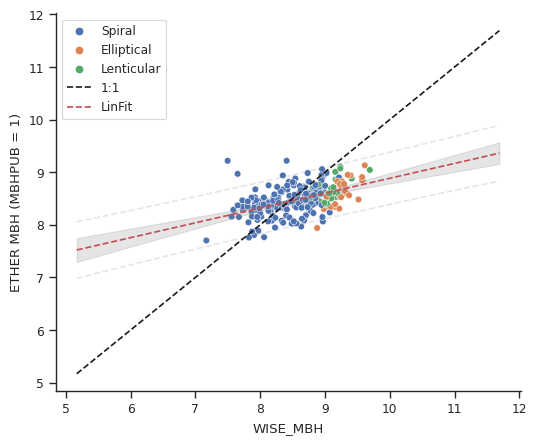

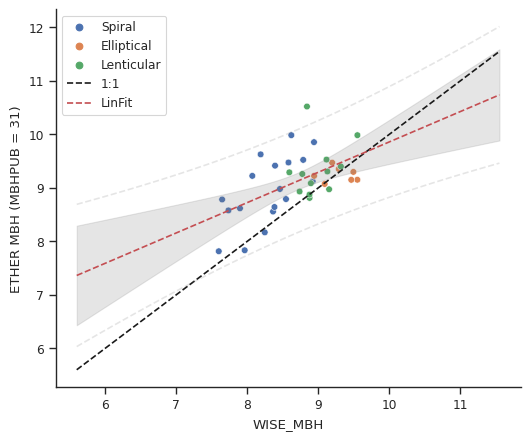

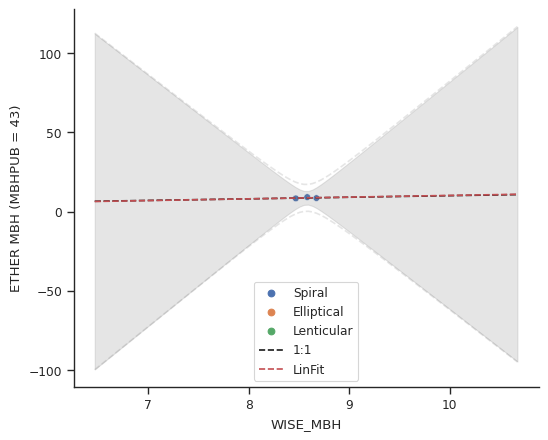

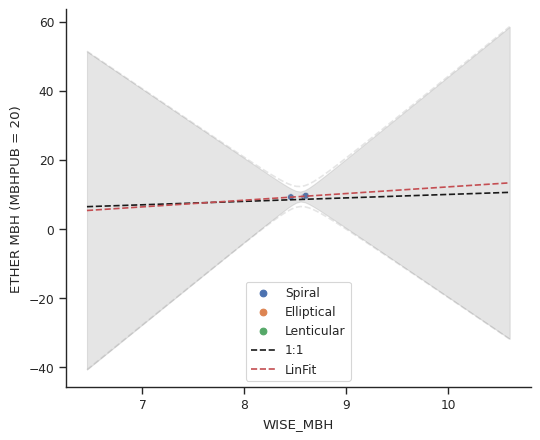

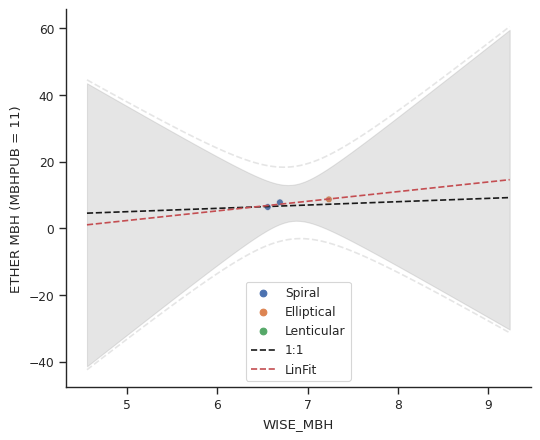

In [16]:
hue_order = ['Spiral', 'Elliptical', 'Lenticular']
for pub_num in pub_nums_vlbi:

    x2, y2, ci1, _, p, pi = f.linear_with_ci(vlbi_only[vlbi_only['MBHPUB']==pub_num]['WISE_MBH'], vlbi_only[vlbi_only['MBHPUB']==pub_num]['MBH'])
    xto1, yto1 = np.linspace(min(x2),max(x2),len(x2)), np.linspace(min(x2),max(x2),len(x2))

    plt.figure(figsize=(6,5), dpi=100)
    sns.scatterplot(x='WISE_MBH', y='MBH', data=vlbi_only[vlbi_only['MBHPUB']==pub_num], hue='MorphType',hue_order=hue_order)
    plt.plot(xto1,yto1, label='1:1', ls='--', c='k')

    plt.plot(x2, y2, '--r', zorder=2,label='LinFit')
    plt.plot(x2, y2-pi, linestyle='--', color='grey', alpha=0.2)
    plt.plot(x2, y2+pi, linestyle='--', color='grey', alpha=0.2)
    plt.fill_between(x2, y2 + ci1, y2 - ci1,color='grey',alpha=0.2)

    plt.ylabel('ETHER MBH (MBHPUB = {})'.format(pub_num))
    plt.legend()

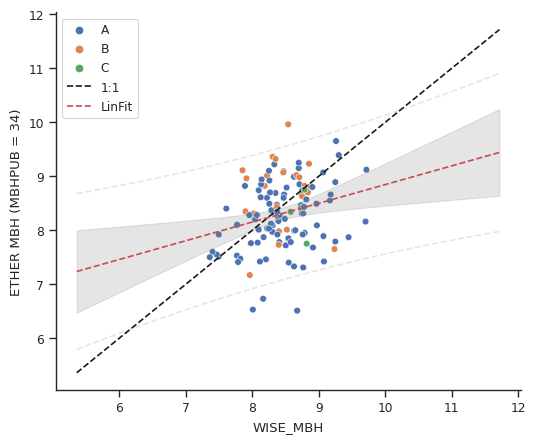

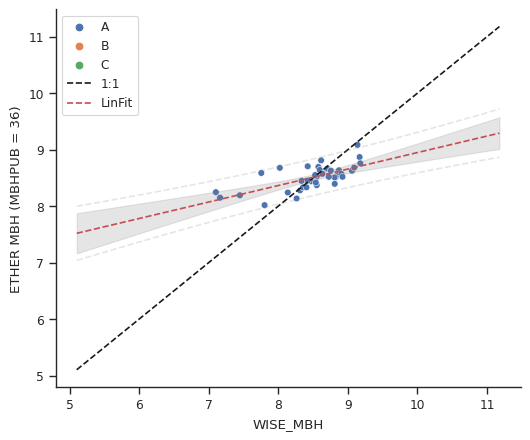

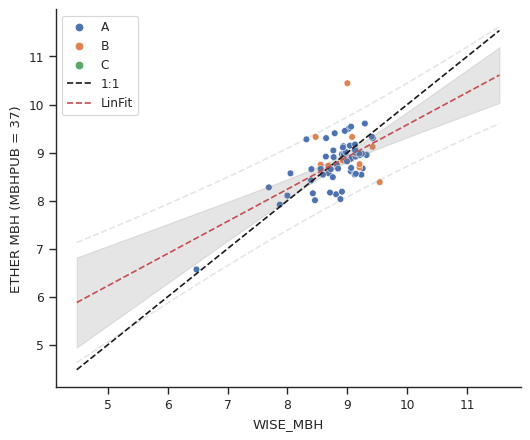

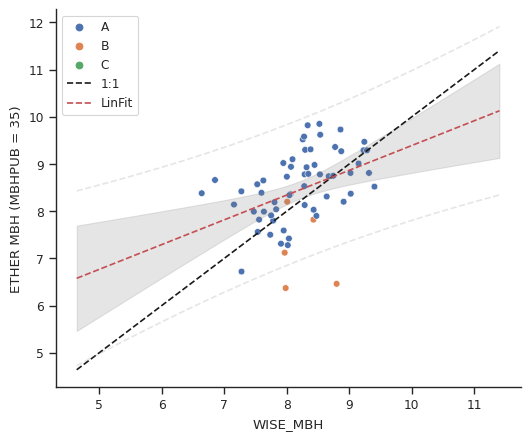

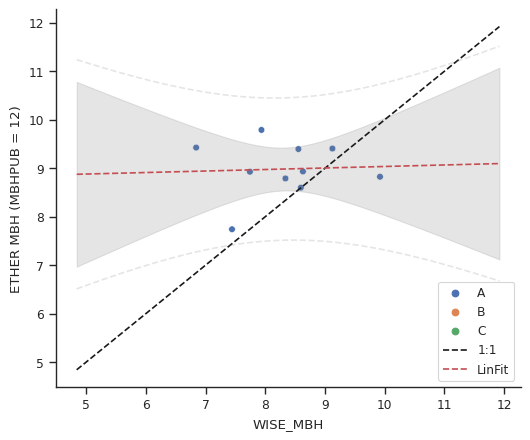

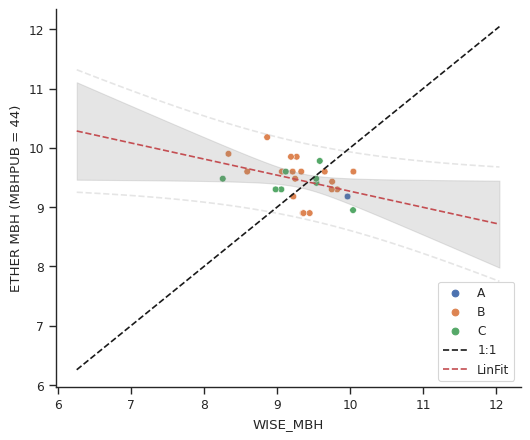

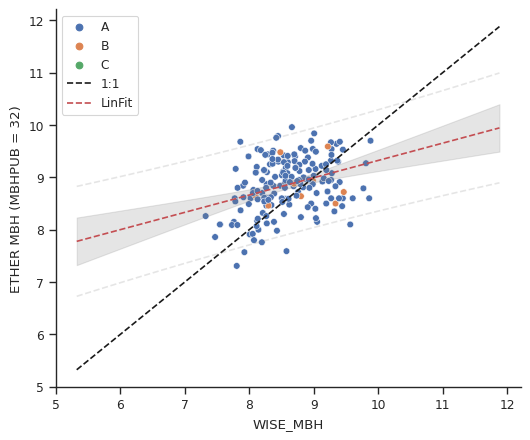

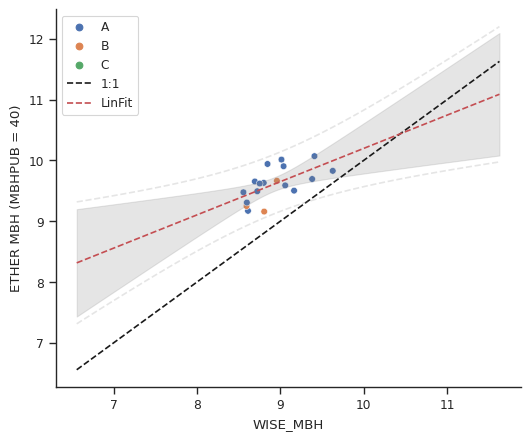

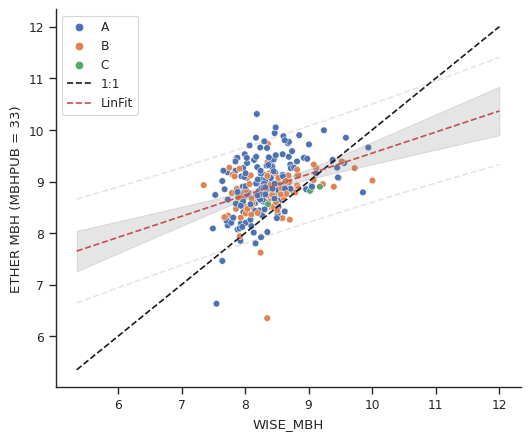

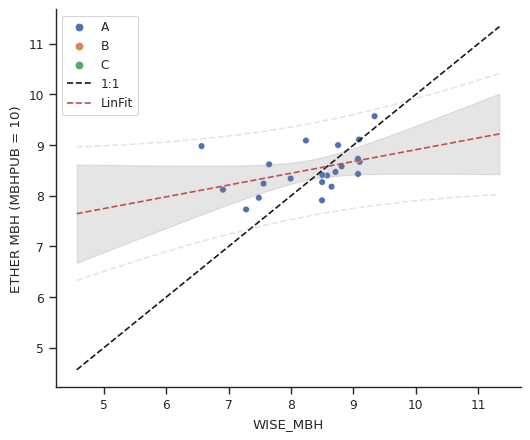

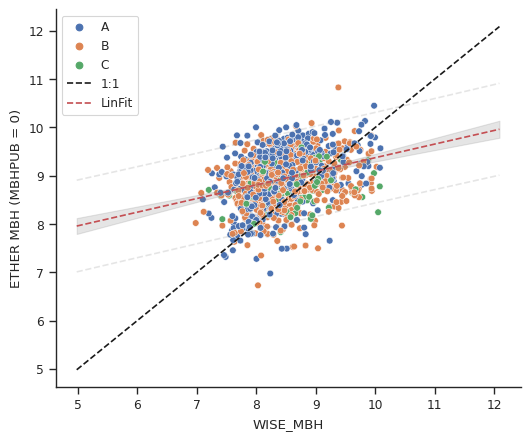

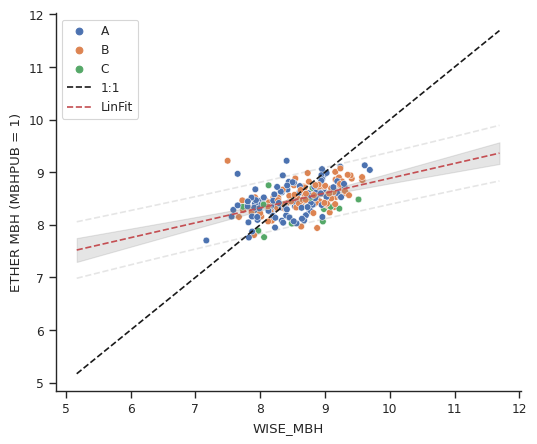

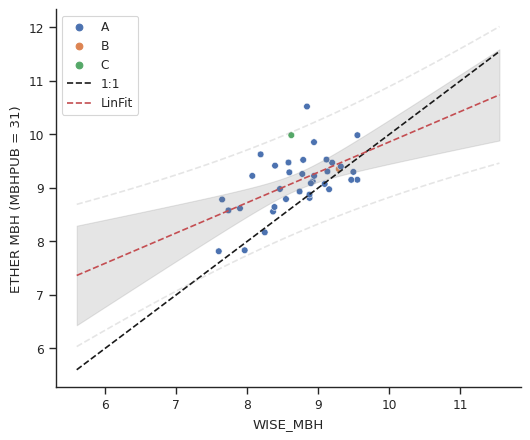

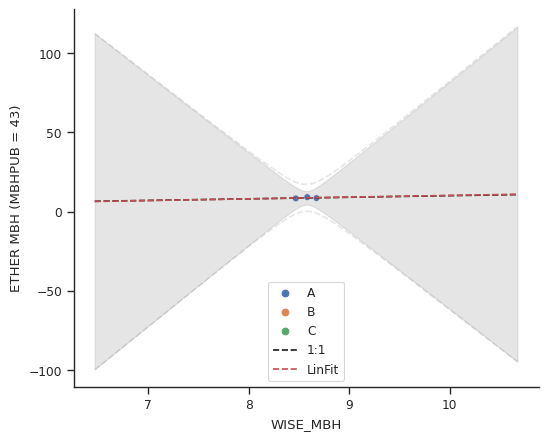

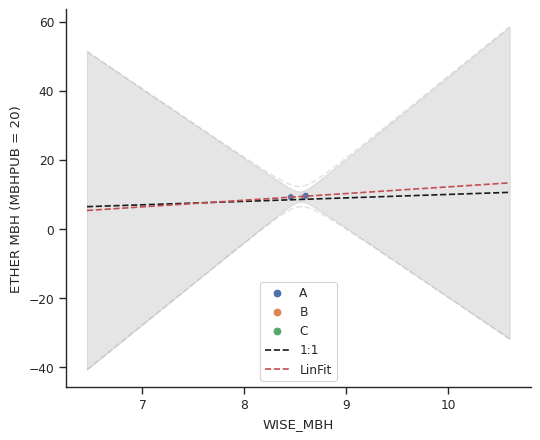

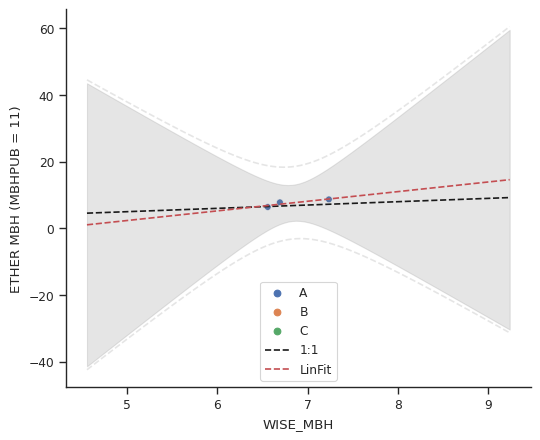

In [17]:
hue_order = ['A', 'B', 'C']
for pub_num in pub_nums_vlbi:

    x2, y2, ci1, _, p, pi = f.linear_with_ci(vlbi_only[vlbi_only['MBHPUB']==pub_num]['WISE_MBH'], vlbi_only[vlbi_only['MBHPUB']==pub_num]['MBH'])
    xto1, yto1 = np.linspace(min(x2),max(x2),len(x2)), np.linspace(min(x2),max(x2),len(x2))

    plt.figure(figsize=(6,5), dpi=100)
    sns.scatterplot(x='WISE_MBH', y='MBH', data=vlbi_only[vlbi_only['MBHPUB']==pub_num], hue='Quality',hue_order=hue_order)
    plt.plot(xto1,yto1, label='1:1', ls='--', c='k')

    plt.plot(x2, y2, '--r', zorder=2,label='LinFit')
    plt.plot(x2, y2-pi, linestyle='--', color='grey', alpha=0.2)
    plt.plot(x2, y2+pi, linestyle='--', color='grey', alpha=0.2)
    plt.fill_between(x2, y2 + ci1, y2 - ci1,color='grey',alpha=0.2)

    plt.ylabel('ETHER MBH (MBHPUB = {})'.format(pub_num))
    plt.legend()

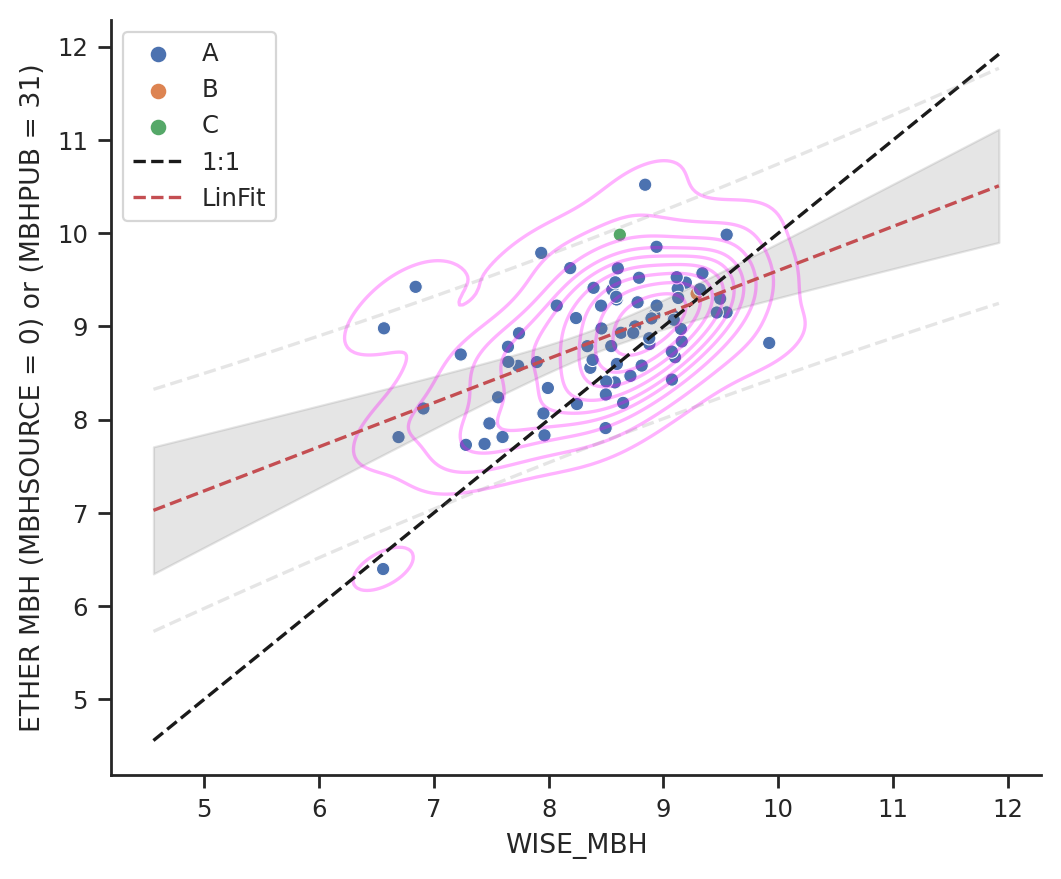

In [18]:
x2, y2, ci1, _, p, pi = f.linear_with_ci(vlbi_only[(vlbi_only['MBHSOURCE']==0) | (vlbi_only['MBHPUB']==31)]['WISE_MBH'], vlbi_only[(vlbi_only['MBHSOURCE']==0) | (vlbi_only['MBHPUB']==31)]['MBH'])
xto1, yto1 = np.linspace(min(x2),max(x2),len(x2)), np.linspace(min(x2),max(x2),len(x2))

plt.figure(figsize=(6,5), dpi=200)
sns.scatterplot(x='WISE_MBH', y='MBH', data=vlbi_only[(vlbi_only['MBHSOURCE']==0) | (vlbi_only['MBHPUB']==31)], hue='Quality',hue_order=hue_order)
sns.kdeplot(x='WISE_MBH', y='MBH', data=vlbi_only[(vlbi_only['MBHSOURCE']==0) | (vlbi_only['MBHPUB']==31)], color='magenta', alpha=0.3)
plt.plot(xto1,yto1, label='1:1', ls='--', c='k')

plt.plot(x2, y2, '--r', zorder=2,label='LinFit')
plt.plot(x2, y2-pi, linestyle='--', color='grey', alpha=0.2)
plt.plot(x2, y2+pi, linestyle='--', color='grey', alpha=0.2)
plt.fill_between(x2, y2 + ci1, y2 - ci1,color='grey',alpha=0.2)

plt.ylabel('ETHER MBH (MBHSOURCE = 0) or (MBHPUB = 31)')
plt.legend()

# T-value image analysis
## Ellipticals

In [19]:
wise_elp = good_quality_wise[good_quality_wise['MorphType']=='Elliptical']
wise_elp

angDist           ONAME          RA        DEC         Z  \
21       0.181584    b'PGC216025'  265.657556 -87.030176  0.044870   
22       0.092704   b'A0013-8716'    3.709960 -86.993120  0.017000   
51       0.129160    b'PGC217252'  122.105293 -85.996080  0.041140   
66       0.249913  b'ESO003-G010'   36.408407 -85.549873  0.015871   
69       0.653503    b'PGC217887'   54.465084 -85.535246  0.042370   
...           ...             ...         ...        ...       ...   
1182428  0.274141        b'IC455'  113.740395  85.537184  0.006838   
1182443  0.270875      b'UGC4297'  127.121894  85.608161  0.006675   
1182453  0.744078      b'NGC2300'  113.085432  85.708857  0.006354   
1182456  0.540148        b'IC499'  131.322065  85.740003  0.006278   
1182511  0.430270      b'NGC1544'   75.650895  86.222325  0.013132   

               DIST           MBH         MBHHI         MBHLO  MBHSOURCE  ...  \
21       177.634890  9.401022e+00  9.537447e+00  9.255903e+00        1.0  ...   
22        71.314900  9.876543e+06  9.876543e+06  9.876543e+06  9876543.0  ...   
51       163.112290  7.719009e+00  8.217435e+00  7.080092e+00        1.0  ...   
66        65.178170  7.906196e+00  8.082288e+00  7.605166e+00        2.0  ...   
69       167.412890  8.422106e+00  8.763100e+00  8.020936e+00        1.0  ...   
...             ...           ...           ...           ...        ...  ...   
1182428   28.081928  7.496846e+00  7.672937e+00  7.195816e+00        2.0  ...   
1182443   27.412529  7.418690e+00  7.594781e+00  7.117660e+00        2.0  ...   
1182453   26.094265  8.364682e+00  8.540773e+00  8.063652e+00        2.0  ...   
1182456   25.782152  7.653030e+00  7.829122e+00  7.352000e+00        2.0  ...   
1182511   53.929787  8.130050e+00  8.306141e+00  7.829020e+00        2.0  ...   

         e_pmDE    d2M  Quality     W1_abs   W1W2   W2W3    T      logSM  \
21         41.0  0.444        A -25.285481 -0.002  0.693 -5.0  11.392113   
22         32.0  0.236        A -24.117632 -0.042  0.548 -5.0  11.003373   
51         56.0  0.109        B -23.891197 -0.032  0.714 -5.0  10.893199   
66         38.0  0.286        A -23.233575 -0.073  0.562 -5.0  10.710510   
69         50.0  0.807        B -23.868092 -0.044  0.354 -5.0  10.907477   
...         ...    ...      ...        ...    ...    ...  ...        ...   
1182428    32.0  0.156        A -21.876414 -0.031  0.600 -5.0  10.085326   
1182443    33.0  0.168        A -21.582756 -0.074  0.464 -5.0  10.052143   
1182453    30.0  0.360        A -23.264207 -0.008  0.564 -5.0  10.595363   
1182456    30.0  0.345        A -21.746952 -0.034  0.457 -5.0  10.039421   
1182511    33.0  0.742        A -23.337745 -0.018  0.529 -5.0  10.644378   

         WISE_MBH   MorphType  
21       9.239820  Elliptical  
22       8.866241  Elliptical  
51       8.760364  Elliptical  
66       8.584800  Elliptical  
69       8.774085  Elliptical  
...           ...         ...  
1182428  7.983998  Elliptical  
1182443  7.952109  Elliptical  
1182453  8.474144  Elliptical  
1182456  7.939883  Elliptical  
1182511  8.521247  Elliptical  

[20639 rows x 52 columns]

In [20]:
elp_sample = pd.DataFrame({'name':wise_elp['ONAME'].str.decode('utf8'),'ra':wise_elp['RA'],'dec':wise_elp['DEC']})
elp_sample

name          ra        dec
21         PGC216025  265.657556 -87.030176
22        A0013-8716    3.709960 -86.993120
51         PGC217252  122.105293 -85.996080
66       ESO003-G010   36.408407 -85.549873
69         PGC217887   54.465084 -85.535246
...              ...         ...        ...
1182428        IC455  113.740395  85.537184
1182443      UGC4297  127.121894  85.608161
1182453      NGC2300  113.085432  85.708857
1182456        IC499  131.322065  85.740003
1182511      NGC1544   75.650895  86.222325

[20639 rows x 3 columns]

In [21]:
elp_sample.to_csv('../WISE/SubSamples/Ellipticals.txt', sep=' ', index=False)

Ellipticals look great. Every single galaxy in SDSS looks like a true Elliptical, so the relation is very good to categorize this kind of galaxies.

In [38]:
good_quality_wise[good_quality_wise['ONAME']==b'1806032012901902336']

angDist                   ONAME          RA        DEC         Z  \
428813  0.211163  b'1806032012901902336'  166.923767  13.025671  0.035013   

          DIST       MBH     MBHHI     MBHLO  MBHSOURCE  ...  e_pmDE    d2M  \
428813  143.73  8.590585  8.629899  8.550365        1.0  ...    46.0  0.167   

        Quality     W1_abs   W1W2   W2W3         T      logSM  WISE_MBH  \
428813        A -24.832389 -0.063  1.652  0.785079  11.330436  8.783444   

        MorphType  
428813     Spiral  

[1 rows x 52 columns]

## Spirals

In [39]:
wise_spr = good_quality_wise[good_quality_wise['MorphType']=='Spiral']
wise_spr = wise_spr[wise_spr['Z']<0.5]

In [40]:
spr_sample = pd.DataFrame({'name':wise_spr['ONAME'].str.decode('utf8'),'ra':wise_spr['RA'],'dec':wise_spr['DEC']})
spr_sample = spr_sample.reset_index().iloc[int(len(spr_sample)/2-10000):int(len(spr_sample)/2+10000)].drop('index', axis=1)
spr_sample


name          ra        dec
105368       2910500256191899648  150.354111  16.570263
105369           SDSSJ13346+1634  203.667083  16.570556
105370  WISEAJ051652.67+163414.5   79.219497  16.570696
105371       2746107869609879552  139.756775  16.570761
105372       2925155923821357056  186.864914  16.570768
...                          ...         ...        ...
125363       3136909224114677760  215.084427  22.614923
125364       3001662141871712256  206.284164  22.615461
125365       2580686343835248640  144.774185  22.615747
125366       2799069971689269248  164.311066  22.615948
125367       2983767319865485312  196.298126  22.616196

[20000 rows x 3 columns]

In [41]:
spr_sample.to_csv('../WISE/SubSamples/Spirals.txt', sep=' ', index=False)

Strangly, some Stars appear in SDSS, which should not append, since I'm using the ETHER coordinates, and just AGN-Galaxy-Quasar-etc are part of the sample. Something to be aware in the future.

# VLBI Morph Analysis

<AxesSubplot:xlabel='WISE_MBH', ylabel='Count'>

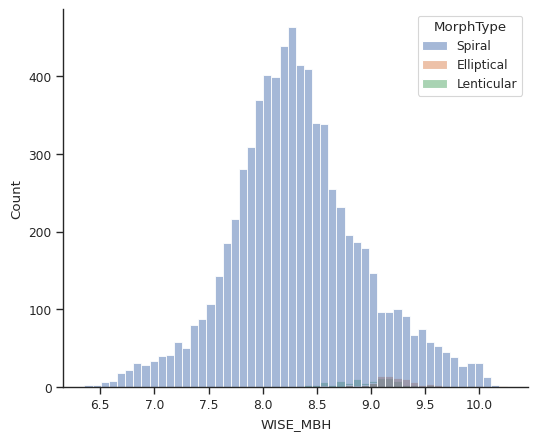

In [25]:
plt.figure(figsize=(6,5), dpi=100)
sns.histplot(data=vlbi_only, x='WISE_MBH', hue='MorphType')

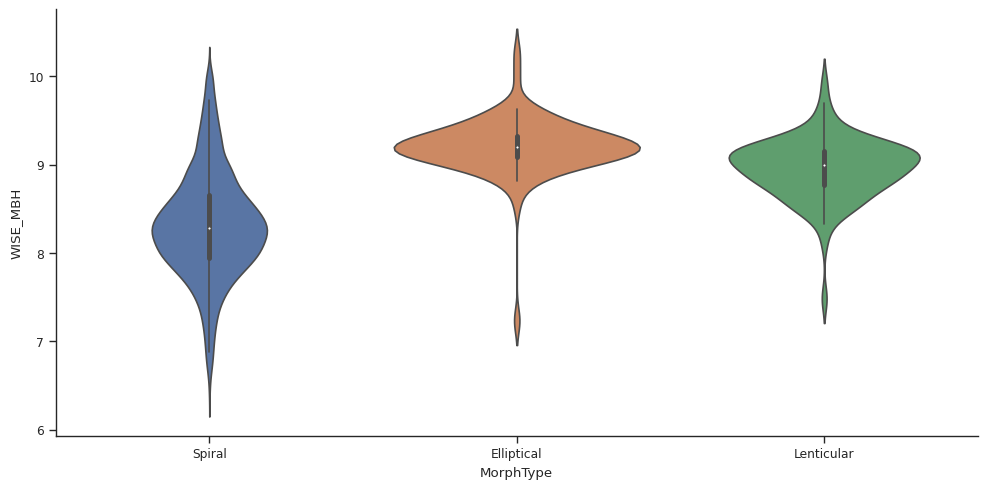

In [26]:
g = sns.catplot(x='MorphType', y='WISE_MBH', kind='violin', data=vlbi_only, height=5, aspect=2)
g.fig.set_dpi(100)

<AxesSubplot:xlabel='WISE_MBH', ylabel='Count'>

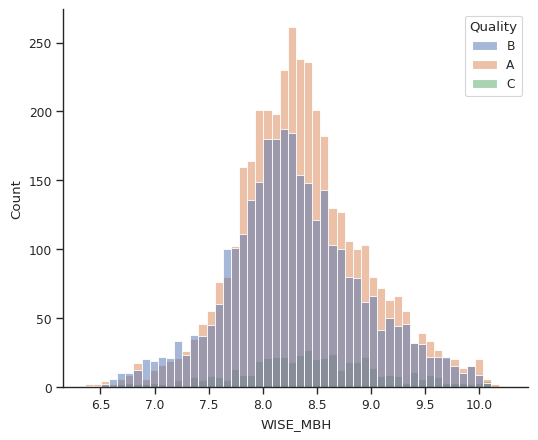

In [27]:
plt.figure(figsize=(6,5), dpi=100)
sns.histplot(data=vlbi_only, x='WISE_MBH', hue='Quality')

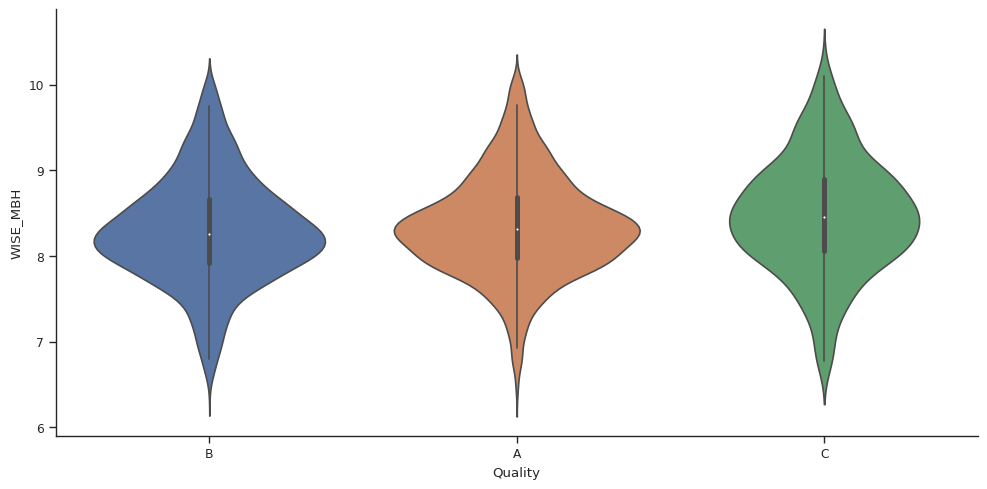

In [28]:
g = sns.catplot(x='Quality', y='WISE_MBH', kind='violin', data=vlbi_only, height=5, aspect=2)
g.fig.set_dpi(100)

In [29]:
vlbi_elp = vlbi_only[vlbi_only['MorphType']=='Elliptical']
vlbi_spr = vlbi_only[vlbi_only['MorphType']=='Spiral']

In [53]:
sum(vlbi_spr['ex']!=0)

886

In [57]:
vlbi_spr['W3W4'] = vlbi_spr['W3mag'] - vlbi_spr['W4mag']

/tmp/ipykernel_4468/1793469963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vlbi_spr['W3W4'] = vlbi_spr['W3mag'] - vlbi_spr['W4mag']


/home/joacoh/.local/lib/python3.10/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


<AxesSubplot:xlabel='W1W2', ylabel='W2W3'>

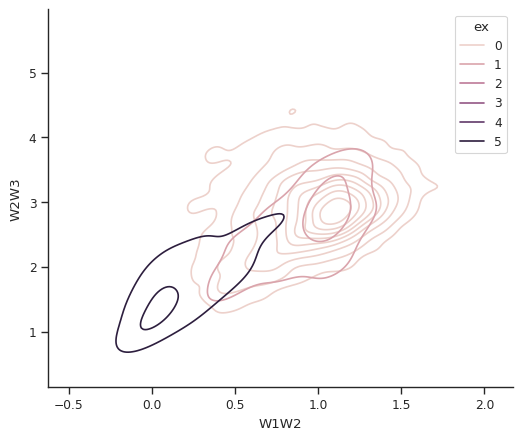

In [60]:
plt.figure(figsize=(6,5), dpi=100)
sns.kdeplot(x='W1W2', y='W2W3', data=vlbi_spr, hue='ex')

In [46]:
vlbi_spr_sample = pd.DataFrame({'ra':vlbi_spr['RA'],'dec':vlbi_spr['DEC']})
vlbi_spr_sample

ra        dec
26       331.441103 -86.896583
64        73.142907 -85.588401
118        2.941270 -84.722225
140      200.614690 -84.326148
167      130.040054 -83.909049
...             ...        ...
1182502  137.907793  86.125987
1182508   24.623488  86.194696
1182531   13.136902  86.462292
1182534  348.957581  86.528777
1182565   33.491028  87.291313

[7341 rows x 2 columns]

In [47]:
vlbi_spr_sample[vlbi_spr['MBH']==no_data]

ra        dec
26       331.441103 -86.896583
64        73.142907 -85.588401
118        2.941270 -84.722225
140      200.614690 -84.326148
167      130.040054 -83.909049
...             ...        ...
1182502  137.907793  86.125987
1182508   24.623488  86.194696
1182531   13.136902  86.462292
1182534  348.957581  86.528777
1182565   33.491028  87.291313

[5071 rows x 2 columns]

In [48]:
vlbi_spr_sample.to_csv('../WISE/SubSamples/VLBI_Spr.txt', sep=' ', index=False)
vlbi_spr_sample[vlbi_spr['MBH']==no_data].to_csv('../WISE/SubSamples/VLBI_Spr_NoMBH.txt', sep=' ', index=False)

In [33]:
vlbi_elp[vlbi_elp['ONAME']==b'NGC1692']

angDist       ONAME         RA        DEC      Z       DIST  \
72169  0.205793  b'NGC1692'  73.848834 -20.571132  0.035  143.67848   

             MBH      MBHHI      MBHLO  MBHSOURCE  ...  e_pmDE    d2M  \
72169  9876543.0  9876543.0  9876543.0  9876543.0  ...    35.0  0.087   

       Quality     W1_abs   W1W2   W2W3    T      logSM  WISE_MBH   MorphType  
72169        A -24.807556 -0.056  0.635 -5.0  11.306782  9.157818  Elliptical  

[1 rows x 52 columns]